In [42]:
import tensorflow as tf

from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.transform import resize
from sklearn.decomposition import PCA
from time import time

#from skimage.transform import resize
#from sklearn.decomposition import PCA
from skimage.feature import canny
from skimage.filters import sobel
from skimage import segmentation
from scipy import ndimage as ndi
#from time import time
from matplotlib.colors import LightSource

from skimage.metrics import structural_similarity, normalized_root_mse

from sklearn import manifold

# Load Images

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
 
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  
  # CONTINUE
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  plt.show()
  if title:
    plt.title(title)
  return imagee

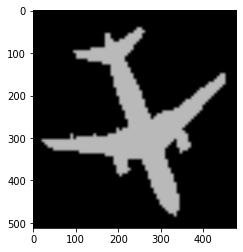

In [133]:
tmp2 = imshow(load_img('/content/tmp2.png'))

# Get cropped images
1. Template Matching
2. Use segmentation on the mask to get the indeces

In [127]:
# Python program to illustrate 
# template matching 
import cv2 
import numpy as np 
from google.colab.patches import cv2_imshow


def template_matching(template_path, image_path, threshold=None):
		img_rgb = cv2.imread(image_path)
		# Convert it to grayscale 
		img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY) 
		# Read the template 
		template = cv2.imread(template_path,0) 

		# Store width and height of template in w and h 
		w, h = template.shape[::-1] 

		# Perform match operations. 
		res = cv2.matchTemplate(img_gray, template,cv2.TM_CCOEFF_NORMED) 
		# show the cross correlation map here.
		plt.imshow(res), plt.show()
		# Specify a threshold 
		# Store the coordinates of matched area in a numpy array 
		if not threshold:
				loc = np.where(res >= res.max()) 
		else:
				loc = np.where(res >= threshold)
		if len(loc)==0:
				print("No matching template!")
				return
		print(loc)
		for pt in zip(*loc[::-1]): 
			cropped_img = img_rgb.copy()[pt[0]:pt[0]+w, pt[1]:pt[1]+h]
			# cv2_imshow(cropped_img)
			plt.imshow(cropped_img), plt.show()
			# Draw a rectangle around the matched region.
			cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
		# Show the final image with the matched area. 
		cv2_imshow(img_rgb)
		return cropped_img

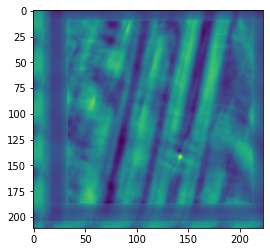

(array([141]), array([142]))


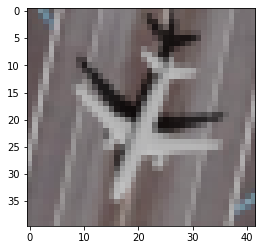

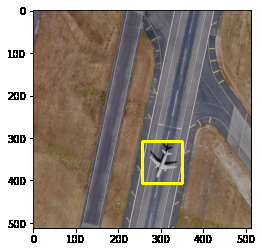

In [128]:
# Read the main image 
tmp_path1 = "/content/tmp.png"
img_path1 = "/content/1.png"
tmp_path2 = "/content/tmp2.png"
img_path2 = "/content/2.png"

cropped_img1 = template_matching(tmp_path1, img_path1)

# PCA

In [75]:
import cv2    
from sklearn import decomposition    
import matplotlib.pyplot as plt 
import numpy as np   

# load data
num_samples = 1
cropped_img = cv2.imread("/content/2.png")

# Convert it to (num_samples, width, height, num_channels)

img = cropped_img.reshape(cropped_img.shape[0], -1)
# img = np.hstack((img.T for i in range(num_samples))).T
print(img.shape)
#Reducing dimension into n components
n_components_ = 10
pca = decomposition.PCA(n_components=n_components_, whiten=True)
pca.fit(img)

(79, 225)


PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

[0.32885736 0.51515878 0.63217308 0.72448705 0.79395944 0.83464887
 0.8659498  0.89284695 0.91751723 0.9348453 ]


0.9175172279069224

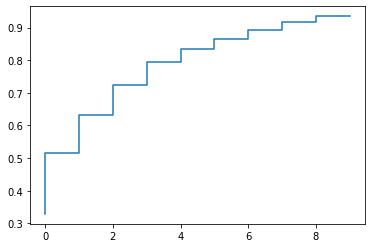

In [78]:
#Cumulative sum of varience ratio of all components
exp_var_cum=np.cumsum(pca.explained_variance_ratio_)
print(exp_var_cum)
plt.step(range(exp_var_cum.size), exp_var_cum)
exp_var_cum[8]

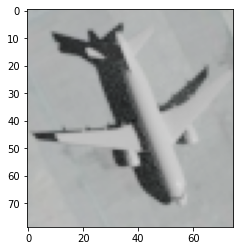

In [79]:
plt.imshow(img.reshape(-1,75,3))

ValueError: ignored

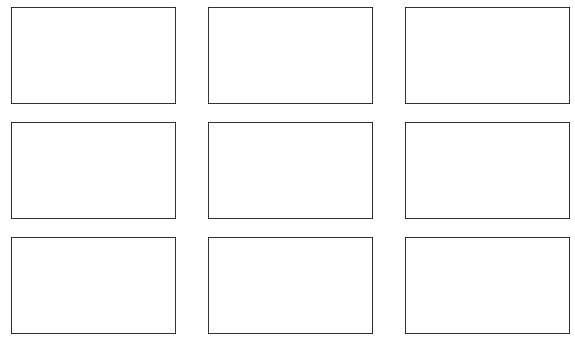

In [80]:
W#Lets see the components from PCA
fig, ax = plt.subplots(3,3, figsize=(10,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(9):
    pixels = pca.components_[i].reshape(79,75,3)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Component - " + str(i+1))

# NMF

reference: http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf

In [25]:
import cv2    
from sklearn import decomposition    
import matplotlib.pyplot as plt 
import numpy as np   

# load data
num_samples = 1
cropped_img = cv2.imread("/content/2.png")
# Convert it to grayscale 
# cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)   
# use all three channels
img = cropped_img.reshape(num_samples, -1)
n_components = 9
nmf = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = nmf.fit_transform(img)
H = nmf.components_

In [28]:
cropped_img.shape, img.shape, W.shape, H.shape

((79, 75, 3), (1, 17775), (1, 9), (9, 17775))

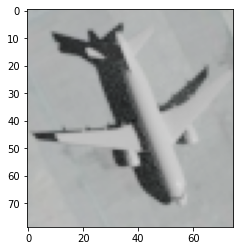

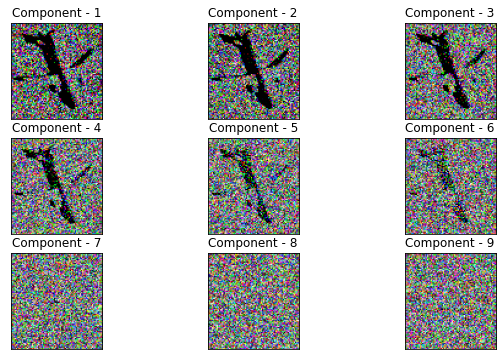

In [39]:
# original data
plt.imshow(cropped_img)
plt.show()

# Lets see the components from NMF
fig, ax = plt.subplots(3, 3, figsize=(10,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(9):
    pixels = nmf.components_[i].reshape(79,75,3)
    pixels_rgb = (pixels * 255).astype(np.uint8) # turn output into rgb channel 
    ax[i].imshow(pixels_rgb)
    ax[i].set_title("Component - " + str(i+1))

### remark

1. template matching: find planes, cropped. 
2. cropped images in the same directions.
3. 

# Localization Using Res50 Feature Map


In [ ]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests

In [ ]:
from torchvision.models._utils import IntermediateLayerGetter

# Refer to https://github.com/pytorch/vision/blob/master/torchvision/models/_utils.py

imagenet_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

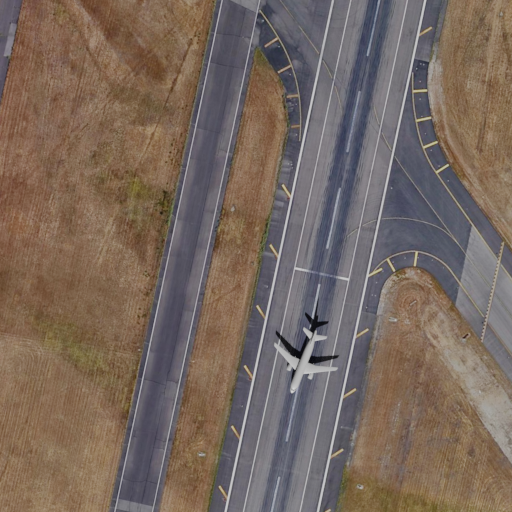

In [ ]:
# PATH
PATH = "/content/drive/My Drive/111 Rendered.ai/rendered/datasets/Airplanes/000/images/0000000005-air.png"
im = PIL.Image.open(PATH).convert("RGB")
im = im.resize((int(im.size[0] * 1), int(im.size[1] * 1)))
im

In [ ]:
# download and send both the model and data to gpu
r50 = torchvision.models.resnet50(pretrained=True).to(device)
X = imagenet_transform(im).unsqueeze(0).to(device)
print(f"Size of input {X.shape}")

Size of input torch.Size([1, 3, 512, 512])


First, let's exam the strucuture of resnet50. The last layer is layer 4. so we can extract this layer from the pretrained model using "IntermediateLayerGetter" function.

In [ ]:
# r50

In [ ]:
def localisation(X, model):
  """
  Generate a localisation map for the predicted class given an input 
  image and a pretrained CNN
  
  Inputs:
  - X: Input image
  - model: Pretrained CNN
  
  Returns:
  - localisation_map : An 2D heatmap 
  """

  # TODO
  model.eval()
  feature_map = IntermediateLayerGetter(model,{'layer4':'feature_map'}) # last layer of resnet 50
  z = feature_map(X)
  z = list(z.values())[0]
  print(z.size())
  z = z.permute(0,2,3,1)    # transpose
  print(z.size())
  z = model.fc(z)           # final fc layer
  print(z.size())
  softmax = nn.Softmax(dim=3)
  logits = softmax(z)
  print(z.size())
  localisation_map = logits[0][:, :, model(X).argmax().item()]
  print(localisation_map.size())

  return localisation_map

In [ ]:
map = localisation(X, r50)

torch.Size([1, 2048, 16, 16])
torch.Size([1, 16, 16, 2048])
torch.Size([1, 16, 16, 1000])
torch.Size([1, 16, 16, 1000])
torch.Size([16, 16])


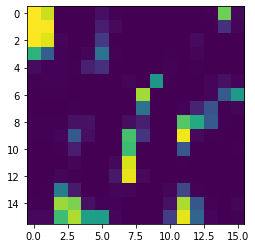

In [ ]:
plt.imshow(map.cpu().detach())
plt.show()

# Pipeline

1. What features are important?
2. Look at the wrongful pictures.
3. Statistical analysis on the wrong pictures...

# Questions
1. 加新的feature/tank对识别有帮助? extra object?
2. 还是shadow? particular feature?

# 新的object? 



# Saliency Map